# Validation of the NuFeb model fitting for S. elongatus


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from scipy.integrate import odeint
from glob import glob
import pickle
from sklearn.linear_model import LinearRegression
from pathlib import Path
from nufeb_tools import utils,plot
import seaborn as sns
from joblib import Parallel, delayed
from sklearn.metrics import r2_score,mean_squared_error
from scipy import interpolate

In [2]:
from math import log10, floor

def find_exp(number:float) -> int:
    base10 = log10(abs(number))
    return floor(base10)

In [3]:
np.logspace(find_exp(1e-6),find_exp(1e-3),5)


array([1.00000000e-06, 5.62341325e-06, 3.16227766e-05, 1.77827941e-04,
       1.00000000e-03])

In [4]:
np.linspace(1e-6,1e-3,5)

array([1.0000e-06, 2.5075e-04, 5.0050e-04, 7.5025e-04, 1.0000e-03])

In [5]:
#int(InitialConditions["Dimensions"][0]*1e6/int(args.grid)
np.ones(shape=[100, 100, 3], dtype=np.uint8).shape[:2]


(100, 100)

Import validation simulation data

In [6]:
BASE_DIR = Path('E:/axenic-se/runs')
folders = [path for path in BASE_DIR.iterdir() if path.is_dir()]

Import experimental data

In [7]:
SucroseMW = 342.3
ExpPath = f'../experimental-data/Biomass CscB-SPS original strain recalculated April 2022.xlsx'
Experimental = pd.read_excel(ExpPath,sheet_name='Compiled')
Experimental.loc[:,'Sucrose_mM'] =Experimental.loc[:,'Sucrose']/SucroseMW*1e3
test_data = pd.read_excel('../experimental-data/sucrose-OD-IPTG-sweep recalculated April 2022.xls',sheet_name='reps')
def od_func(x):
    """Exponential fit to IPTG vs OD750 experimental data

    Args:
        x (float): IPTG concentration (mM)

    Returns:
        float: Smoothed OD750
    """
    return 0.25482 * np.exp(-x/.06811) + 1.12893
# Smooth OD750 data for fitting
#test_data.loc[:,'OD750'] = od_func(test_data.IPTG)

In [8]:
def collect_data(folder):
    x = utils.get_data(directory=str(folder))
    Volume = np.prod(x.metadata['Dimensions'])
    CellNum2OD = Volume*1e6/0.3e-8
    Biomass2OD = .2825*Volume*1e18
    temp = pd.concat([x.biomass.cyano.reset_index(drop=True)/Biomass2OD,x.biomass.step.reset_index(drop=True)/60/60*x.timestep,x.avg_con.Sucrose.reset_index(drop=True),x.biomass.cyano.reset_index(drop=True)/1e18/Volume],axis=1)
    temp.columns=['OD750','Hours','Sucrose','Biomass']
    temp['IPTG'] = x.metadata['IPTG']
    temp['SucroseMass']=temp.Sucrose*SucroseMW/1e3
    temp['TotalBiomass'] = temp.Biomass + temp.SucroseMass
    temp['RelativeBiomass'] = temp.Biomass/temp.TotalBiomass
    temp['RelativeSucrose'] = temp.SucroseMass/temp.TotalBiomass
    return temp

Use nufeb-tools to collect data from all simulation folders listed above

In [9]:
#data = [utils.get_data(directory=str(x)) for x in folders]
tmp=Parallel(n_jobs=-1)(delayed(collect_data)(folder) for folder in folders)
df = pd.concat(tmp,ignore_index=True)
df.head()

,OD750,Hours,Sucrose,Biomass,IPTG,SucroseMass,TotalBiomass,RelativeBiomass,RelativeSucrose
0,0.297712,0.000000,9.991236e-20,0.084104,0.0,3.420000e-20,0.084104,1.000000,4.066415e-19
1,0.303049,0.277778,4.811776e-05,0.085611,0.0,1.647071e-05,0.085628,0.999808,1.923521e-04
2,0.308483,0.555556,9.558063e-05,0.087146,0.0,3.271725e-05,0.087179,0.999625,3.752877e-04
3,0.314014,0.833333,1.438842e-04,0.088709,0.0,4.925156e-05,0.088758,0.999445,5.548964e-04
4,0.319644,1.111111,1.930485e-04,0.090299,0.0,6.608049e-05,0.090365,0.999269,7.312586e-04


Compile datasets into one dataframe

In [10]:
""" Volume = np.prod(data[0].metadata['Dimensions'])
CellNum2OD = Volume*1e6/0.3e-8

dfs = []
for x in data:
    temp = pd.concat([x.ntypes.cyano/CellNum2OD,x.ntypes.step/60/60*x.timestep,x.avg_con.Sucrose.reset_index(drop=True),x.biomass.cyano.reset_index(drop=True)/1e18/Volume],axis=1)
    temp.columns=['OD750','Hours','Sucrose','Biomass']
    temp['IPTG'] = x.metadata['IPTG']
    temp['SucroseMass']=temp.Sucrose*SucroseMW/1e3
    temp['TotalBiomass'] = temp.Biomass + temp.SucroseMass
    temp['RelativeBiomass'] = temp.Biomass/temp.TotalBiomass
    temp['RelativeSucrose'] = temp.SucroseMass/temp.TotalBiomass
    dfs.append(temp)
df = pd.concat(dfs,ignore_index=True)
#df = df.loc[(df.Hours > 23.8) & (df.Hours < 24)]
#df.sort_values(by='IPTG',inplace=True)
#df.reset_index(inplace=True)
df.head() """

" Volume = np.prod(data[0].metadata['Dimensions'])\nCellNum2OD = Volume*1e6/0.3e-8\n\ndfs = []\nfor x in data:\n    temp = pd.concat([x.ntypes.cyano/CellNum2OD,x.ntypes.step/60/60*x.timestep,x.avg_con.Sucrose.reset_index(drop=True),x.biomass.cyano.reset_index(drop=True)/1e18/Volume],axis=1)\n    temp.columns=['OD750','Hours','Sucrose','Biomass']\n    temp['IPTG'] = x.metadata['IPTG']\n    temp['SucroseMass']=temp.Sucrose*SucroseMW/1e3\n    temp['TotalBiomass'] = temp.Biomass + temp.SucroseMass\n    temp['RelativeBiomass'] = temp.Biomass/temp.TotalBiomass\n    temp['RelativeSucrose'] = temp.SucroseMass/temp.TotalBiomass\n    dfs.append(temp)\ndf = pd.concat(dfs,ignore_index=True)\n#df = df.loc[(df.Hours > 23.8) & (df.Hours < 24)]\n#df.sort_values(by='IPTG',inplace=True)\n#df.reset_index(inplace=True)\ndf.head() "

In [11]:
test_data

,IPTG,OD750,Sucrose
0,0.000,1.38,0.002614
1,0.005,1.40,0.010347
2,0.010,1.50,0.044766
3,0.020,1.37,0.125368
4,0.050,1.24,0.219911
...,...,...,...
58,0.050,NaN,NaN
59,0.100,NaN,NaN
60,0.200,NaN,NaN
61,0.500,NaN,NaN


Make a dataframe for 24 hr data to match some of the experimental data

In [12]:
df24 = df.loc[(df.Hours == df.Hours.iloc[-1])]
df24.sort_values(by='IPTG',inplace=True)
df24.reset_index(inplace=True)
df24.head()

C:\Users\sakkosjo\AppData\Local\Temp\ipykernel_8880\269784903.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df24.sort_values(by='IPTG',inplace=True)


,index,OD750,Hours,Sucrose,Biomass,IPTG,SucroseMass,TotalBiomass,RelativeBiomass,RelativeSucrose
0,87,1.396970,24.166667,0.009597,0.394644,0.000,0.003285,0.397929,0.991744,0.008256
1,175,1.396950,24.166667,0.009597,0.394639,0.000,0.003285,0.397924,0.991744,0.008256
2,263,1.394308,24.166667,0.009579,0.393892,0.000,0.003279,0.397171,0.991744,0.008256
3,967,1.391849,24.166667,0.017241,0.393197,0.001,0.005902,0.399099,0.985213,0.014787
4,879,1.393369,24.166667,0.017259,0.393627,0.001,0.005908,0.399535,0.985213,0.014787


In [13]:
Experimental.head()

,Time,OD750,IPTG,Biomass,Sucrose,Total Biomass,% Sucrose,% Biomass,Biomass Ratio,Unnamed: 9,...,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Sucrose_mM
0,0,0.271,0.0,0.075790,0.002091,0.077881,0.026854,0.973146,0.027595,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006110
1,0,0.300,0.0,0.090530,0.003137,0.093667,0.033492,0.966508,0.034653,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009165
2,0,0.270,0.0,0.077890,0.002711,0.080601,0.033632,0.966368,0.034803,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007919
3,6,0.440,0.0,0.130530,0.002827,0.133357,0.021201,0.978799,0.021660,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008260
4,6,0.396,0.0,0.136842,0.002711,0.139553,0.019427,0.980573,0.019812,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007920


In [14]:
Experimental.IPTG.unique()

array([0.  , 0.01, 1.  ])

In [15]:
tmp = df24.groupby('IPTG').mean().reset_index()

for i in df24.IPTG.unique():
    df24.loc[df24.IPTG==i,'SucroseMass2']=df24.loc[df24.IPTG==i,'SucroseMass']+ tmp.loc[tmp.IPTG==i,'Biomass'].values[0]
    df24.loc[df24.IPTG==i,'RelativeSucrose2']=df24.loc[df24.IPTG==i,'RelativeSucrose']+ tmp.loc[tmp.IPTG==i,'RelativeBiomass'].values[0]
exp_mean = test_data.groupby('IPTG').mean().reset_index()
means = df24.groupby('IPTG').mean().reset_index()[['IPTG','OD750','Sucrose']]
g=interpolate.interp1d(means.IPTG,means.OD750)
growth_r2=r2_score(exp_mean.OD750,g(exp_mean.IPTG))
s =interpolate.interp1d(means.IPTG,means.Sucrose)
suc_r2=r2_score(exp_mean.Sucrose,s(exp_mean.IPTG))

c:\Users\sakkosjo\Anaconda3\envs\nufeb\lib\site-packages\pandas\core\indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
c:\Users\sakkosjo\Anaconda3\envs\nufeb\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\Users\sakkosjo\Anaconda3\envs\nufeb\lib\site-packages\pandas\core\indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Helper function to make the figure panel labels

In [16]:

from matplotlib import transforms
import matplotlib as mpl
def label_panel(ax, letter, *,
                offset_left=0.5, offset_up=0.1, prefix='', postfix='', **font_kwds):
    kwds = dict(fontsize=18)
    kwds.update(font_kwds)
    # this mad looking bit of code says that we should put the code offset a certain distance in
    # inches (using the fig.dpi_scale_trans transformation) from the top left of the frame
    # (which is (0, 1) in ax.transAxes transformation space)
    fig = ax.figure
    trans = ax.transAxes + transforms.ScaledTranslation(-offset_left, offset_up, fig.dpi_scale_trans)
    ax.text(0, 1, prefix+letter+postfix, transform=trans, **kwds)
def colorFader(c1,c2,n): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    
    mix = np.linspace(0,1,n+1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    cols = list()
    for i in range(n):
        cols.append(mpl.colors.to_hex((1-mix[i])*c1 + mix[i]*c2))
    return cols
def colorFaderRGB(c1,c2,n): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)

    mix = np.linspace(0,1,n+1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    cols = list()
    for i in range(n):
        cols.append(tuple((((1-mix[i])*c1 + mix[i]*c2)*256).astype('int')))
    return cols


Plot figure

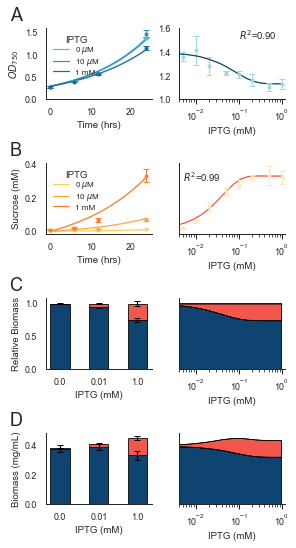

In [17]:
fig = plt.figure(constrained_layout=True, figsize=(4, 7.5))
gs0 = gridspec.GridSpec(4, 2, figure=fig)
sns.set_context("paper")
sns.set_style("white")
capsize = 3
capthick = 1
markersize=3
# colors=
od_pal = [
    "#52bfd9",
    "#348fb1",
    "#19699a",
]  # ['#deebf7','#56B4F0','#3182bd']#colorFader('#b7d6eb','#1878b5',3)#['#deebf7','#9ecae1','#3182bd']'#56B4F0'
suc_pal = [
    "#ffd059",
    "#faa644",
    "#f58131",
]  # ['#ebaeae','#F06E6E','#c73838']#colorFader('#decaca','#F06E6E',3)#['#fee0d2','#fc9272','#de2d26']#['#094067','#90b4ce','#5f6c7b']#['#3da9fc','#ef4565','#5f6c7b']
c_suc = ["#104470", "#f1574c"]  # ['#56B4F0','#F06E6E']
c_exp = "#094067"

# OD vs time
ax1 = fig.add_subplot(gs0[0, 0])
sns.lineplot(
    x="Hours",
    y="OD750",
    hue="IPTG",
    ci="sd",
    data=df[(df.IPTG == 0) | (df.IPTG == 0.01) | (df.IPTG == 1)],
    ax=ax1,
    palette=od_pal,
)
for iptg,color in zip(Experimental.IPTG.unique(),od_pal):
    temp =Experimental.loc[Experimental.IPTG==iptg].groupby('Time')
    mean = temp.mean().reset_index()
    std = temp.std().reset_index()
    ax1.errorbar(
    x=mean['Time'],
    y=mean['OD750'],
    yerr=std['OD750'],
    color=color,
    capsize=capsize,
    capthick=capthick,
    ls="",
    marker="o",
    ms=markersize,
    )
labels = [r"0 $\mu$M", r"10 $\mu$M", "1 mM"]
handles, _ = ax1.get_legend_handles_labels()
ax1.legend(
    handles,
    labels,
    frameon=False,
    title="IPTG",
    fontsize=8,
    labelspacing=0.1,
    loc="upper left",
)
# ax1.legend(frameon=False,title='IPTG (mM)')
ax1.set_xlabel("Time (hrs)")
ax1.set_ylabel(r"$OD_{750}$")
ax1.set_ylim(0, 1.6)

# Sucrose vs time
ax2 = fig.add_subplot(gs0[1, 0])
sns.lineplot(
    x="Hours",
    y="Sucrose",
    hue="IPTG",
    ci="sd",
    data=df[(df.IPTG == 0) | (df.IPTG == 0.01) | (df.IPTG == 1)],
    palette=suc_pal,
    ax=ax2,
)
for iptg,color in zip(Experimental.IPTG.unique(),suc_pal):
    temp =Experimental.loc[Experimental.IPTG==iptg].groupby('Time')
    mean = temp.mean().reset_index()
    std = temp.std().reset_index()
    ax2.errorbar(
    x=mean['Time'],
    y=mean['Sucrose_mM'],
    yerr=std['Sucrose_mM'],
    color=color,
    capsize=capsize,
    capthick=capthick,
    ls="",
    marker="o",
    ms=markersize,
    )
""" sns.scatterplot(
    x="Time",
    y="Sucrose_mM",
    hue="IPTG",
    ci="sd",
    data=Experimental,
    ax=ax2,
    palette=suc_pal,
    legend=False,
) """
handles, _ = ax2.get_legend_handles_labels()
ax2.legend(
    handles,
    labels,
    frameon=False,
    title="IPTG",
    fontsize=8,
    labelspacing=0.1,
    loc="upper left",
)
# ax2.legend(frameon=False,title='IPTG (mM)')
ax2.set_xlabel("Time (hrs)")
ax2.set_ylabel("Sucrose (mM)")

# OD vs IPTG @ 24 hrs
with sns.axes_style("ticks"):
    ax3 = fig.add_subplot(gs0[0, 1])
    sns.lineplot(x="IPTG", y="OD750", ci="sd", data=df24, ax=ax3, color=c_suc[0])
    ax3.errorbar(
        x=test_data.groupby("IPTG").mean().reset_index()["IPTG"],
        y=test_data.groupby("IPTG").mean().reset_index()["OD750"],
        yerr=test_data.groupby("IPTG").std().reset_index()["OD750"],
        c="#9fd9de",
        capsize=capsize,
        capthick=capthick,
        ls="",
        marker="o",
        ms=markersize,
    )
    # sns.scatterplot(x='IPTG',y='OD750',ci='sd',data=test_data,ax=ax3,color='#9fd9de')
    ax3.set_xscale("log")
    ax3.set_xlabel("IPTG (mM)")
    ax3.set_ylabel("")
    # ax3.set_ylabel(r'$OD_{750}$')
    ax3.set_ylim(1, 1.6)
    ax3.set_xlim(4e-3, 1.2e0)
    ax3.text(0.1, 1.5, f"$R^2$={growth_r2:.2f}")
# Sucrose vs IPTG @ 24 hrs
with sns.axes_style("ticks"):
    ax4 = fig.add_subplot(gs0[1, 1], sharey=ax2)
    sns.lineplot(x="IPTG", y="Sucrose", ci="sd", data=df24, ax=ax4, color=c_suc[1])
    #sns.scatterplot(
    #    x="IPTG", y="Sucrose", ci="sd", data=test_data, ax=ax4, color="#ffe6b2"
    #)
    ax4.errorbar(
    x=test_data.groupby("IPTG").mean().reset_index()["IPTG"],
    y=test_data.groupby("IPTG").mean().reset_index()["Sucrose"],
    yerr=test_data.groupby("IPTG").std().reset_index()["Sucrose"],
    c="#ffe6b2",
    capsize=capsize,
    capthick=capthick,
    ls="",
    marker="o",
    ms=markersize,
    )
    ax4.set_xscale("log")
    ax4.set_xlabel("IPTG (mM)")
    ax4.set_ylabel("")
    ax4.set_xlim(4e-3, 1.2e0)
    ax4.text(0.005, 0.3, f"$R^2$={suc_r2:.2f}")
width = 0.5

pctBiomass = (
    Experimental.loc[Experimental.Time == 24].groupby("IPTG").mean()["% Biomass"]
)
pctSucrose = (
    Experimental.loc[Experimental.Time == 24].groupby("IPTG").mean()["% Sucrose"]
)
pctBiomassErr = (
    Experimental.loc[Experimental.Time == 24].groupby("IPTG").std()["% Biomass"]
)
pctSucroseErr = (
    Experimental.loc[Experimental.Time == 24].groupby("IPTG").std()["% Sucrose"]
)


Biomass = Experimental.loc[Experimental.Time == 24].groupby("IPTG").mean()["Biomass"]
BiomassErr = Experimental.loc[Experimental.Time == 24].groupby("IPTG").std()["Biomass"]
Sucrose = Experimental.loc[Experimental.Time == 24].groupby("IPTG").mean()["Sucrose"]
SucroseErr = Experimental.loc[Experimental.Time == 24].groupby("IPTG").std()["Sucrose"]
# Relative biomass, experimental

# ax7 = fig.add_subplot(gs0[2, 1],sharey=ax5)
ax5 = fig.add_subplot(gs0[2, 0])
ax5.bar(
    Experimental.IPTG.unique().astype("str"),
    pctBiomass,
    width,
    yerr=pctBiomassErr,
    label="Cell Biomass",
    edgecolor="k",
    color=c_suc[0],
    ecolor="black",
    capsize=capsize,
)
ax5.bar(
    Experimental.IPTG.unique().astype("str"),
    pctSucrose,
    width,
    yerr=pctSucroseErr,
    bottom=pctBiomass,
    label="Cell Biomass",
    edgecolor="k",
    color=c_suc[1],
    ecolor="black",
    capsize=capsize,
)
# ax5.set_title('Experimental')
ax5.set_xlabel("IPTG (mM)")
ax5.set_ylabel("Relative Biomass")

# Total biomass, experimental

# ax8 = fig.add_subplot(gs0[3, 1],sharey=ax6)
ax6 = fig.add_subplot(gs0[3, 0])
ax6.bar(
    Experimental.IPTG.unique().astype("str"),
    Biomass,
    width,
    yerr=BiomassErr,
    label="Cell Biomass",
    edgecolor="k",
    color=c_suc[0],
    ecolor="black",
    capsize=3,
)
ax6.bar(
    Experimental.IPTG.unique().astype("str"),
    Sucrose,
    width,
    yerr=SucroseErr,
    bottom=Biomass,
    label="Cell Biomass",
    edgecolor="k",
    color=c_suc[1],
    ecolor="black",
    capsize=3,
)
ax6.set_xlabel("IPTG (mM)")
ax6.set_ylabel("Biomass (mg/mL)")

# ax6.set_title('Experimental')
# Relative biomass, simulated
with sns.axes_style("ticks"):
    # ax5 = fig.add_subplot(gs0[2, 0])
    ax7 = fig.add_subplot(gs0[2, 1], sharey=ax5)
    ax7.stackplot(
        df24.IPTG.unique(),
        df24.groupby("IPTG").mean().RelativeBiomass,
        df24.groupby("IPTG").mean().RelativeSucrose,
        colors=c_suc,
        edgecolor="k",
    )  #'#5f6c7b','#094067',
    sns.lineplot(
        x=df24.IPTG, y=df24.RelativeBiomass, ci="sd", ax=ax7, color="k", lw=0.5
    )
    sns.lineplot(
        x=df24.IPTG, y=df24.RelativeSucrose2, ci="sd", ax=ax7, color="k", lw=0.5
    )
    ax7.set_ylabel("")
    ax7.set_xscale("log")
    ax7.set_xlabel("IPTG (mM)")
    ax7.set_xlim(4e-3, 1.2e0)
    # ax7.set_title('Simulated')

# Total biomass, simulated
with sns.axes_style("ticks"):
    # ax6 = fig.add_subplot(gs0[3, 0])
    ax8 = fig.add_subplot(gs0[3, 1], sharey=ax6)
    ax8.stackplot(
        df24.IPTG.unique(),
        df24.groupby("IPTG").mean().Biomass,
        df24.groupby("IPTG").mean().SucroseMass,
        colors=c_suc,
        edgecolor="k",
    )
    sns.lineplot(x=df24.IPTG, y=df24.Biomass, ci="sd", ax=ax8, color="k", lw=0.5)
    sns.lineplot(x=df24.IPTG, y=df24.SucroseMass2, ci="sd", ax=ax8, color="k", lw=0.5)
    ax8.set_ylabel("")
    ax8.set_xscale("log")
    ax8.set_xlabel("IPTG (mM)")
    ax8.set_xlim(4e-3, 1.2e0)
    
    # ax8.set_title('Simulated')


for ax in [ax3, ax4, ax5, ax6, ax7, ax8]:
    ax.tick_params(left=False)
plt.setp(ax4.get_yticklabels(), visible=False)
plt.setp(ax7.get_yticklabels(), visible=False)
plt.setp(ax8.get_yticklabels(), visible=False)
label_panel(ax1, "A")
label_panel(ax2, "B")
# label_panel(ax3,'B')
# label_panel(ax4,'D')
label_panel(ax5, "C")
label_panel(ax6, "D")
# label_panel(ax7,'F')
# label_panel(ax8,'H')
sns.despine()
# fig.tight_layout()
fig.align_ylabels()
#fig.savefig(r"../figures/se-validation-single-column.pdf", bbox_inches="tight")



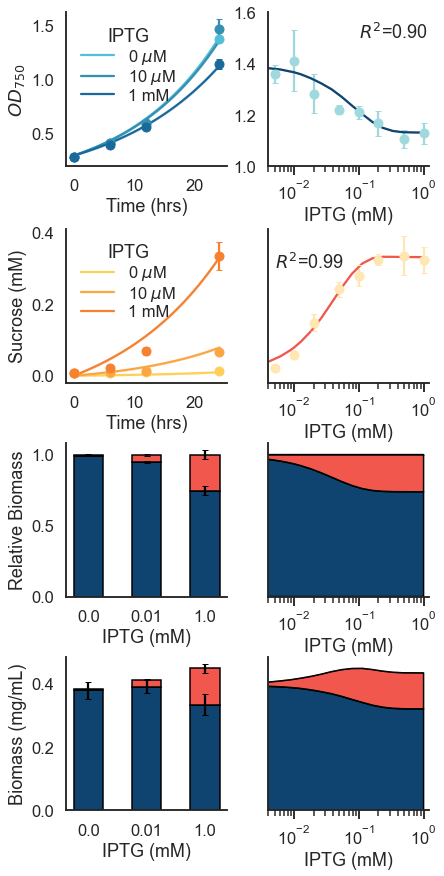

In [42]:
sns.set_context('talk')
fig = plt.figure(constrained_layout=True, figsize=(6, 12))
gs0 = gridspec.GridSpec(4, 2, figure=fig)
sns.set_style("white")
capsize = 3
capthick = 1
markersize=3
# colors=
od_pal = [
    "#52bfd9",
    "#348fb1",
    "#19699a",
]  # ['#deebf7','#56B4F0','#3182bd']#colorFader('#b7d6eb','#1878b5',3)#['#deebf7','#9ecae1','#3182bd']'#56B4F0'
suc_pal = [
    "#ffd059",
    "#faa644",
    "#f58131",
]  # ['#ebaeae','#F06E6E','#c73838']#colorFader('#decaca','#F06E6E',3)#['#fee0d2','#fc9272','#de2d26']#['#094067','#90b4ce','#5f6c7b']#['#3da9fc','#ef4565','#5f6c7b']
c_suc = ["#104470", "#f1574c"]  # ['#56B4F0','#F06E6E']
c_exp = "#094067"

# OD vs time
ax1 = fig.add_subplot(gs0[0, 0])
sns.lineplot(
    x="Hours",
    y="OD750",
    hue="IPTG",
    ci="sd",
    data=df[(df.IPTG == 0) | (df.IPTG == 0.01) | (df.IPTG == 1)],
    ax=ax1,
    palette=od_pal,
)
for iptg,color in zip(Experimental.IPTG.unique(),od_pal):
    temp =Experimental.loc[Experimental.IPTG==iptg].groupby('Time')
    mean = temp.mean().reset_index()
    std = temp.std().reset_index()
    ax1.errorbar(
    x=mean['Time'],
    y=mean['OD750'],
    yerr=std['OD750'],
    color=color,
    capsize=capsize,
    ls="",
    marker="o",
    )
labels = [r"0 $\mu$M", r"10 $\mu$M", "1 mM"]
handles, _ = ax1.get_legend_handles_labels()
ax1.legend(
    handles,
    labels,
    frameon=False,
    title="IPTG",
    labelspacing=0.1,
    loc="upper left",
)
# ax1.legend(frameon=False,title='IPTG (mM)')
ax1.set_xlabel("Time (hrs)")
ax1.set_ylabel(r"$OD_{750}$")
#ax1.set_ylim(0, 1.6)

# Sucrose vs time
ax2 = fig.add_subplot(gs0[1, 0])
sns.lineplot(
    x="Hours",
    y="Sucrose",
    hue="IPTG",
    ci="sd",
    data=df[(df.IPTG == 0) | (df.IPTG == 0.01) | (df.IPTG == 1)],
    palette=suc_pal,
    ax=ax2,
)
for iptg,color in zip(Experimental.IPTG.unique(),suc_pal):
    temp =Experimental.loc[Experimental.IPTG==iptg].groupby('Time')
    mean = temp.mean().reset_index()
    std = temp.std().reset_index()
    ax2.errorbar(
    x=mean['Time'],
    y=mean['Sucrose_mM'],
    yerr=std['Sucrose_mM'],
    color=color,
    capsize=capsize,
    ls="",
    marker="o",

    )
handles, _ = ax2.get_legend_handles_labels()
ax2.legend(
    handles,
    labels,
    frameon=False,
    title="IPTG",
    labelspacing=0.1,
    loc="upper left",
)
# ax2.legend(frameon=False,title='IPTG (mM)')
ax2.set_xlabel("Time (hrs)")
ax2.set_ylabel("Sucrose (mM)")

# OD vs IPTG @ 24 hrs
with sns.axes_style("ticks"):
    ax3 = fig.add_subplot(gs0[0, 1])
    sns.lineplot(x="IPTG", y="OD750", ci="sd", data=df24, ax=ax3, color=c_suc[0])
    ax3.errorbar(
        x=test_data.groupby("IPTG").mean().reset_index()["IPTG"],
        y=test_data.groupby("IPTG").mean().reset_index()["OD750"],
        yerr=test_data.groupby("IPTG").std().reset_index()["OD750"],
        c="#9fd9de",
        capsize=capsize,
        ls="",
        marker="o",
    )
    ax3.set_xscale("log")
    ax3.set_xlabel("IPTG (mM)")
    ax3.set_ylabel("")

    ax3.set_ylim(1, 1.6)
    ax3.set_xlim(4e-3, 1.2e0)
    ax3.text(0.1, 1.5, f"$R^2$={growth_r2:.2f}")
# Sucrose vs IPTG @ 24 hrs
with sns.axes_style("ticks"):
    ax4 = fig.add_subplot(gs0[1, 1], sharey=ax2)
    sns.lineplot(x="IPTG", y="Sucrose", ci="sd", data=df24, ax=ax4, color=c_suc[1])

    ax4.errorbar(
    x=test_data.groupby("IPTG").mean().reset_index()["IPTG"],
    y=test_data.groupby("IPTG").mean().reset_index()["Sucrose"],
    yerr=test_data.groupby("IPTG").std().reset_index()["Sucrose"],
    c="#ffe6b2",
    capsize=capsize,
    capthick=capthick,
    ls="",
    marker="o",
    )
    ax4.set_xscale("log")
    ax4.set_xlabel("IPTG (mM)")
    ax4.set_ylabel("")
    ax4.set_xlim(4e-3, 1.2e0)
    ax4.text(0.005, 0.3, f"$R^2$={suc_r2:.2f}")
width = 0.5

pctBiomass = (
    Experimental.loc[Experimental.Time == 24].groupby("IPTG").mean()["% Biomass"]
)
pctSucrose = (
    Experimental.loc[Experimental.Time == 24].groupby("IPTG").mean()["% Sucrose"]
)
pctBiomassErr = (
    Experimental.loc[Experimental.Time == 24].groupby("IPTG").std()["% Biomass"]
)
pctSucroseErr = (
    Experimental.loc[Experimental.Time == 24].groupby("IPTG").std()["% Sucrose"]
)


Biomass = Experimental.loc[Experimental.Time == 24].groupby("IPTG").mean()["Biomass"]
BiomassErr = Experimental.loc[Experimental.Time == 24].groupby("IPTG").std()["Biomass"]
Sucrose = Experimental.loc[Experimental.Time == 24].groupby("IPTG").mean()["Sucrose"]
SucroseErr = Experimental.loc[Experimental.Time == 24].groupby("IPTG").std()["Sucrose"]
# Relative biomass, experimental

ax5 = fig.add_subplot(gs0[2, 0])
ax5.bar(
    Experimental.IPTG.unique().astype("str"),
    pctBiomass,
    width,
    yerr=pctBiomassErr,
    label="Cell Biomass",
    edgecolor="k",
    color=c_suc[0],
    ecolor="black",
    capsize=capsize,
)
ax5.bar(
    Experimental.IPTG.unique().astype("str"),
    pctSucrose,
    width,
    yerr=pctSucroseErr,
    bottom=pctBiomass,
    label="Cell Biomass",
    edgecolor="k",
    color=c_suc[1],
    ecolor="black",
    capsize=capsize,
)

ax5.set_xlabel("IPTG (mM)")
ax5.set_ylabel("Relative Biomass")

# Total biomass, experimental
ax6 = fig.add_subplot(gs0[3, 0])
ax6.bar(
    Experimental.IPTG.unique().astype("str"),
    Biomass,
    width,
    yerr=BiomassErr,
    label="Cell Biomass",
    edgecolor="k",
    color=c_suc[0],
    ecolor="black",
    capsize=3,
)
ax6.bar(
    Experimental.IPTG.unique().astype("str"),
    Sucrose,
    width,
    yerr=SucroseErr,
    bottom=Biomass,
    label="Cell Biomass",
    edgecolor="k",
    color=c_suc[1],
    ecolor="black",
    capsize=3,
)
ax6.set_xlabel("IPTG (mM)")
ax6.set_ylabel("Biomass (mg/mL)")

# Relative biomass, simulated
with sns.axes_style("ticks"):

    ax7 = fig.add_subplot(gs0[2, 1], sharey=ax5)
    ax7.stackplot(
        df24.IPTG.unique(),
        df24.groupby("IPTG").mean().RelativeBiomass,
        df24.groupby("IPTG").mean().RelativeSucrose,
        colors=c_suc,
        edgecolor="k",
    )
    sns.lineplot(
        x=df24.IPTG, y=df24.RelativeBiomass, ci="sd", ax=ax7, color="k", lw=0.5
    )
    sns.lineplot(
        x=df24.IPTG, y=df24.RelativeSucrose2, ci="sd", ax=ax7, color="k", lw=0.5
    )
    ax7.set_ylabel("")
    ax7.set_xscale("log")
    ax7.set_xlabel("IPTG (mM)")
    ax7.set_xlim(4e-3, 1.2e0)


# Total biomass, simulated
with sns.axes_style("ticks"):
    ax8 = fig.add_subplot(gs0[3, 1], sharey=ax6)
    ax8.stackplot(
        df24.IPTG.unique(),
        df24.groupby("IPTG").mean().Biomass,
        df24.groupby("IPTG").mean().SucroseMass,
        colors=c_suc,
        edgecolor="k",
    )
    sns.lineplot(x=df24.IPTG, y=df24.Biomass, ci="sd", ax=ax8, color="k", lw=0.5)
    sns.lineplot(x=df24.IPTG, y=df24.SucroseMass2, ci="sd", ax=ax8, color="k", lw=0.5)
    ax8.set_ylabel("")
    ax8.set_xscale("log")
    ax8.set_xlabel("IPTG (mM)")
    ax8.set_xlim(4e-3, 1.2e0)
    
    # ax8.set_title('Simulated')


for ax in [ax3, ax4, ax5, ax6, ax7, ax8]:
    ax.tick_params(left=False)
plt.setp(ax4.get_yticklabels(), visible=False)
plt.setp(ax7.get_yticklabels(), visible=False)
plt.setp(ax8.get_yticklabels(), visible=False)

sns.despine()

fig.align_ylabels()
fig.savefig(r"../figures/se-validation-talk.png", bbox_inches="tight",dpi=600)



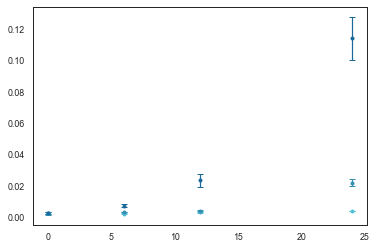

In [18]:

for iptg,color in zip(Experimental.IPTG.unique(),od_pal):
    temp =Experimental.loc[Experimental.IPTG==iptg].groupby('Time')
    mean = temp.mean().reset_index()
    std = temp.std().reset_index()
    plt.errorbar(
    x=mean['Time'],
    y=mean['Sucrose'],
    yerr=std['Sucrose'],
    color=color,
    capsize=capsize,
    capthick=capthick,
    ls="",
    marker="o",
    ms=markersize,
    )


In [19]:
for key, grp in Experimental.groupby(["IPTG",'Time']).agg([np.mean,np.std]):
    print(key, grp)

OD750 mean
OD750 std
Biomass mean
Biomass std
Sucrose mean
Sucrose std
Total Biomass mean
Total Biomass std
% Sucrose mean
% Sucrose std
% Biomass mean
% Biomass std
Biomass Ratio mean
Biomass Ratio std
Unnamed: 9 mean
Unnamed: 9 std
Unnamed: 10 mean
Unnamed: 10 std
Unnamed: 11 mean
Unnamed: 11 std
Unnamed: 12 mean
Unnamed: 12 std
Unnamed: 13 mean
Unnamed: 13 std
Unnamed: 14 mean
Unnamed: 14 std
Unnamed: 15 mean
Unnamed: 15 std
Unnamed: 16 mean
Unnamed: 16 std
Unnamed: 17 mean
Unnamed: 17 std
Unnamed: 18 mean
Unnamed: 18 std
Unnamed: 19 mean
Unnamed: 19 std
Sucrose_mM mean
Sucrose_mM std


In [20]:
Experimental.groupby(["IPTG",'Time']).agg([np.mean,np.std])['OD750','mean']

IPTG  Time
0.00  0       0.280333
      6       0.415000
      12      0.588000
      24      1.380000
0.01  0       0.280667
      6       0.413333
      12      0.602000
      24      1.473333
1.00  0       0.280667
      6       0.396333
      12      0.562333
      24      1.146667
Name: (OD750, mean), dtype: float64

In [21]:
Experimental.loc[(Experimental.IPTG==1) & (Experimental.Time==24)]['Total Biomass'].mean()/Experimental.loc[(Experimental.IPTG==0) & (Experimental.Time==24)]['Total Biomass'].mean()

1.172209674775568